In [28]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [29]:
def load_images(path, img_size=(100,100)):
    X = []
    y = []
    label = 0

    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            continue
        
        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: 
                continue
            
            img = cv2.resize(img, img_size)
            X.append(img.flatten())  
            y.append(label)
        
        label += 1
    
    return np.array(X).T, np.array(y)  # X = (mn × p)


In [30]:
def compute_mean(X):
    M = np.mean(X, axis=1).reshape(-1,1)
    return M


In [31]:
def mean_zero(X, M):
    return X - M


In [32]:
def surrogate_covariance(D):
    return D.T @ D


In [33]:
def compute_eigen(C):
    eigvals, eigvecs = np.linalg.eigh(C)
    idx = np.argsort(eigvals)[::-1]           # sort decreasing
    return eigvals[idx], eigvecs[:, idx]


In [34]:
def get_feature_vectors(D, eigvecs, k):
    V = eigvecs[:, :k]
    Psi = D @ V
    Psi = Psi / np.linalg.norm(Psi, axis=0)
    return Psi


In [35]:
def eigenfaces(Psi):
    return Psi.T


In [36]:
def face_signatures(Phi, D):
    return Phi @ D


In [37]:
def train_ann(X_train, y_train):
    ann = MLPClassifier(hidden_layer_sizes=(50,), max_iter=500)
    ann.fit(X_train.T, y_train)
    return ann


In [38]:

def load_images_single_folder(path, img_size=(100,100)):
    X = []
    y = []
    label = 0  # all same class OR modify if needed

    for file in os.listdir(path):
        if not file.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".pgm")):
            continue

        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print("Failed to read:", img_path)
            continue

        img = cv2.resize(img, img_size)
        X.append(img.flatten())
        y.append(label)

    X = np.array(X).T  # shape = (mn, p)
    y = np.array(y)
    return X, y



In [39]:
dataset_path = r"C:\Users\crahu\Downloads\faces\motion_blurred"

X, y = load_images_single_folder(dataset_path)   # FIXED LOADER
print("X shape:", X.shape)

M = compute_mean(X)
D = mean_zero(X, M)
C = surrogate_covariance(D)
eigvals, eigvecs = compute_eigen(C)

accuracies = []
k_values = [5, 10, 20, 30, 40, 50]

for k in k_values:
    if k > D.shape[1]:  # prevent crash when k > number of images
        print(f"Skipping k={k} because k > number of samples")
        continue

    Psi = get_feature_vectors(D, eigvecs, k)
    Phi = eigenfaces(Psi)
    Omega = face_signatures(Phi, D)

    # training ANN
    X_train, X_test, y_train, y_test = train_test_split(
        Omega.T, y, test_size=0.4, random_state=42
    )

    ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=800)
    ann.fit(X_train, y_train)

    y_pred = ann.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    print(f"k = {k} → Accuracy = {acc:.4f}")


X shape: (10000, 350)
k = 5 → Accuracy = 1.0000
k = 10 → Accuracy = 1.0000
k = 20 → Accuracy = 1.0000
k = 30 → Accuracy = 1.0000
k = 40 → Accuracy = 1.0000
k = 50 → Accuracy = 1.0000


In [40]:
print(type(X))
print(X.shape)
print(len(y))


<class 'numpy.ndarray'>
(10000, 350)
350


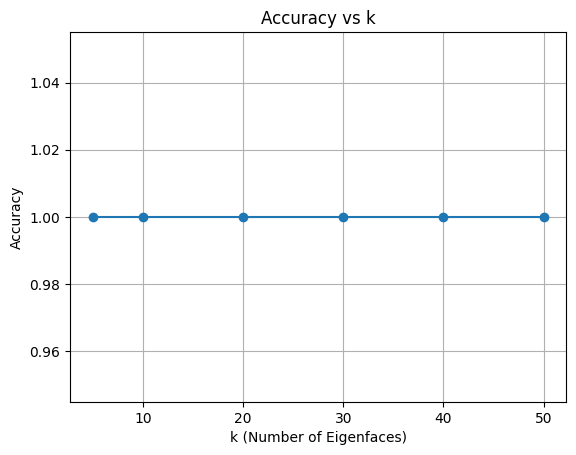

In [41]:
plt.plot(k_values, accuracies, marker='o')
plt.xlabel("k (Number of Eigenfaces)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs k")
plt.grid()
plt.show()


In [42]:
def predict_with_imposter(model, Phi, M, img):
    img = cv2.resize(img, (100,100)).flatten().reshape(-1,1)
    I2 = img - M
    Omega_test = Phi @ I2
    
    prob = model.predict_proba(Omega_test.T)[0]
    
    if np.max(prob) < 0.35:      # threshold
        return "IMPOSTER"
    else:
        return model.predict(Omega_test.T)[0]


In [43]:
import os
import cv2
import numpy as np

path = r"C:\Users\crahu\Downloads\faces\motion_blurred"

files = sorted([f for f in os.listdir(path) 
                if f.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".pgm"))])

print("Sorted file names:")
print(files[:5])

image_data = []

for file in files[:5]:   # only first 5 images
    img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (100,100))
    image_data.append(img.flatten())

image_data = np.array(image_data)
print("Shape of 5 image data:", image_data.shape)


Sorted file names:
['0_IPHONE-SE_M.JPG', '100_NIKON-D3400-35MM_M.JPG', '101_NIKON-D3400-35MM_M.JPG', '102_NIKON-D3400-35MM_M.JPG', '103_HUAWEI-P20_M.jpg']
Shape of 5 image data: (5, 10000)


Showing these 5 images:
['0_IPHONE-SE_M.JPG', '100_NIKON-D3400-35MM_M.JPG', '101_NIKON-D3400-35MM_M.JPG', '102_NIKON-D3400-35MM_M.JPG', '103_HUAWEI-P20_M.jpg']


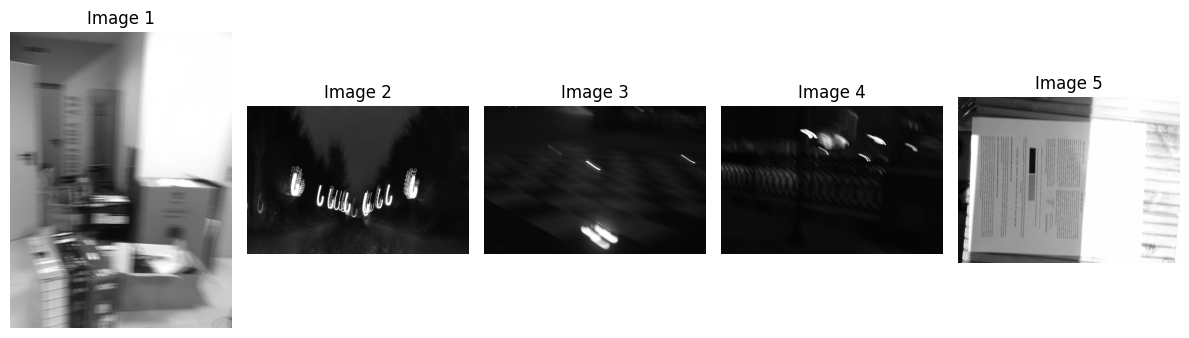

In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = r"C:\Users\crahu\Downloads\faces\motion_blurred"

# Get sorted image files
files = sorted([f for f in os.listdir(path) 
                if f.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".pgm"))])

# Take first 5 files
files5 = files[:5]

print("Showing these 5 images:")
print(files5)

plt.figure(figsize=(12,6))

for i, file in enumerate(files5):
    img_path = os.path.join(path, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is not None:
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()


In [48]:
import cv2
import numpy as np
import os

def wiener_deblur(img, kernel_size=7):
    # Create averaging blur kernel
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)

    # Fourier transforms
    img_fft = np.fft.fft2(img)
    kernel_fft = np.fft.fft2(kernel, s=img.shape)

    # Avoid division by zero
    kernel_fft = np.where(kernel_fft == 0, 1e-8, kernel_fft)

    # Wiener Filter
    K = 0.02   # noise-to-signal ratio
    result_fft = np.conj(kernel_fft) / (np.abs(kernel_fft)**2 + K) * img_fft

    result = np.abs(np.fft.ifft2(result_fft))
    return np.clip(result, 0, 255).astype(np.uint8)


# --------- PATHS ---------
input_path = r"C:\Users\crahu\Downloads\faces\motion_blurred"
output_path = r"C:\Users\crahu\Downloads\faces\deblurred"

os.makedirs(output_path, exist_ok=True)

# Get first 10 sorted images
files = sorted([f for f in os.listdir(input_path)
                if f.lower().endswith((".jpg", ".png", ".jpeg", ".bmp", ".pgm"))])[:10]

print("Processing these 10 images:")
print(files)

# --------- PROCESS 10 IMAGES ---------
for file in files:
    img = cv2.imread(os.path.join(input_path, file), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Cannot read:", file)
        continue

    # Apply Wiener deblur
    deblurred = wiener_deblur(img, kernel_size=7)

    # Save output
    save_path = os.path.join(output_path, "deblur_" + file)
    cv2.imwrite(save_path, deblurred)

print("\nDeblurred 10 images saved in:", output_path)


Processing these 10 images:
['0_IPHONE-SE_M.JPG', '100_NIKON-D3400-35MM_M.JPG', '101_NIKON-D3400-35MM_M.JPG', '102_NIKON-D3400-35MM_M.JPG', '103_HUAWEI-P20_M.jpg', '104_IPHONE-SE_M.jpg', '105_IPHONE-SE_M.jpg', '106_NIKON-D3400-35MM_M.JPG', '107_XIAOMI-MI8-SE_M.jpg', '108_XIAOMI-MI8-SE_M.jpg']

Deblurred 10 images saved in: C:\Users\crahu\Downloads\faces\deblurred
